# Import Libraries

In [53]:
import os, sys, json, cv2, time, glob, gc, datetime, pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches
import seaborn as sns; sns.set(font_scale=1.4)
import keras_tuner as kt
import warnings

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

warnings.filterwarnings("ignore")

# Configurations

In [2]:
CSV_PATH = './df.csv'
ARR_PATH = './natural_scene_data.npz'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMAGE_SIZE = (150, 150)
IMG_SIZE = 150
BATCH_SIZE = 32
N_CLASSES = 6
N_ROWS = 10

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Check if a GPU is available and set the device
if tf.config.experimental.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("GPU is available")
else:
    device = '/CPU:0'
    print("GPU is not available, using CPU")

GPU is available


# Data Loading

In [3]:
df = pd.read_csv(CSV_PATH)
df.head()

,Image,Label,Label_names,Split
0,[[[0.24313726 0.28235295 0.38039216]\n [0.101...,1,street,train
1,[[[0.8117647 0.8117647 0.85882354]\n [0.796...,3,buildings,train
2,[[[0.18431373 0.1764706 0.09411765]\n [0.337...,1,street,train
3,[[[0.3647059 0.4627451 0.72156864]\n [0.368...,0,mountain,val
4,[[[0.2509804 0.3254902 0.21568628]\n [0.137...,5,forest,train


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image        17034 non-null  object
 1   Label        17034 non-null  int64 
 2   Label_names  17034 non-null  object
 3   Split        17034 non-null  object
dtypes: int64(1), object(3)
memory usage: 532.4+ KB


In [5]:
data = np.load(ARR_PATH, allow_pickle=True)
X_train, X_val, Y_train, Y_val, X_test, labels_dict = data['X_train'], data['X_val'], data['Y_train'], data['Y_val'], data['X_test'], data['labels_dict']
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, X_test.shape)
labels_dict

(14034, 150, 150, 3) (3000, 150, 150, 3) (14034,) (3000,) (7301, 150, 150, 3)


array({'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5},
      dtype=object)

In [6]:
labels_dict = labels_dict.tolist()
labels_dict = {v: k for k, v in labels_dict.items()}
labels_dict

{0: 'mountain',
 1: 'street',
 2: 'glacier',
 3: 'buildings',
 4: 'sea',
 5: 'forest'}

In [7]:
if N_ROWS:
    X_train = X_train[:N_ROWS]
    Y_train = Y_train[:N_ROWS]
    X_val = X_val[:N_ROWS]
    Y_val = Y_val[:N_ROWS]
    X_test = X_test[:N_ROWS]
    EPOCHS = 2

In [8]:
# Convert Y_train to one-hot encoded format
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)
Y_train_one_hot.shape, Y_val_one_hot.shape

((10, 6), (10, 6))

In [9]:
# Define a function to apply random transformations to images
def random_transform(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change the contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly change the saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly change the hue
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])  # Randomly crop the image

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]
    
    def random_zoom(image):
        crops = tf.image.crop_and_resize([image], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
    
    image = random_zoom(image)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

In [10]:
# Create a tf.data.Dataset from X_train and Y_train
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_one_hot))
train_dataset = train_dataset.map(random_transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Apply random transformations
train_dataset = train_dataset.batch(BATCH_SIZE)  # Batch the dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Create a tf.data.Dataset from X_val and Y_val
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val_one_hot))
val_dataset = val_dataset.batch(BATCH_SIZE)  # Batch the dataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Create a tf.data.Dataset from X_test
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(BATCH_SIZE)  # Batch the dataset
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Print the dataset shapes to verify
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

for images, labels in val_dataset.take(1):
    print(images.shape, labels.shape)

for images in test_dataset.take(1):
    print(images.shape)

(10, 150, 150, 3) (10, 6)
(10, 150, 150, 3) (10, 6)
(10, 150, 150, 3)


In [11]:
def plot_metrics(history, model, val_dataset=val_dataset, labels_dict=labels_dict):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('learning_rate', []),
    }
    
    # Calculate F1-score for each epoch (if precision and recall are available)
    metrics['f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                           for p, r in zip(metrics['precision'], metrics['recall'])]
    metrics['val_f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                               for p, r in zip(metrics['val_precision'], metrics['val_recall'])]

    epochs = range(1, len(metrics['loss']) + 1)

    plt.figure(figsize=(33, 22))

    # Plot Loss
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot Precision
    plt.subplot(3, 3, 2)
    plt.plot(metrics['precision'], label='Train Precision')
    plt.plot(metrics['val_precision'], label='Val Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot Recall
    plt.subplot(3, 3, 3)
    plt.plot(metrics['recall'], label='Train Recall')
    plt.plot(metrics['val_recall'], label='Val Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot F1-score
    plt.subplot(3, 3, 4)
    plt.plot(metrics['f1_score'], label='Train F1-Score')
    plt.plot(metrics['val_f1_score'], label='Val F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot AUC
    plt.subplot(3, 3, 5)
    plt.plot(metrics['auc'], label='Train AUC')
    plt.plot(metrics['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot learning rate
    plt.subplot(3, 3, 6)
    plt.plot(metrics['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    result = model.get_val_info(val_dataset)
    y_true, y_pred_prob = result['y_true'], result['y_pred_prob']
    
    # ROC Curve for each class
    num_classes = y_pred_prob.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.subplot(3, 3, 7)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} {labels_dict[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Precision-Recall Curve for each class
    plt.subplot(3, 3, 8)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i} {labels_dict[i]}')
    plt.title('Precision-Recall Curve for Each Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Custom CNN

In [12]:
class CustomCNNModel:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))

        # Output Layer for classification
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with 6 units for 6 classes
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=[
                               'accuracy',  # Built-in accuracy for sparse labels
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc', multi_label=True),  # AUC for multiclass
                  ])
        
    def train(self, train_dataset=train_dataset, val_dataset=val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def validation(self, val_dataset=val_dataset):
        results = self.model.evaluate(val_dataset)
        loss, accuracy, precision, recall, auc = results
        print(f'Testing Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')
        return {
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auc': auc
        }
    
    def get_val_info(self, val_dataset=val_dataset):
        # Get true labels and predicted probabilities
        y_true = []
        y_pred_prob = []
        
        # Iterate through validation dataset and collect true labels and predicted probabilities
        for batch in val_dataset:
            x_val, y_val = batch  # x_val: validation features, y_val: validation true labels
            y_true.extend(y_val.numpy())  # Collect true labels
            
            # Predict the probabilities for each class
            preds = self.model.predict(x_val)
            y_pred_prob.extend(preds)
        
        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_true = np.argmax(y_true, axis=-1)  # Convert one-hot encoded labels to categorical labels
        y_pred_prob = np.array(y_pred_prob)

        return {
            'y_true': y_true,  # Return true labels
            'y_pred_prob': y_pred_prob  # Return predicted probabilities
        }

    
    def predict_batch(self, test_dataset=test_dataset, labels_dict=labels_dict):
        predictions = self.model.predict(test_dataset)
        predictions = tf.argmax(predictions, axis=-1)
        predictions = np.vectorize(labels_dict.get)(predictions)
        return predictions
    
    def predict_single(self, image, labels_dict=labels_dict):
        # Image shape should be (150, 150, 3)
        result = self.model.predict(np.expand_dims(image, axis=0))
        result = np.array(result)[0]
        result = labels_dict[result]
        return result
    
    def save(self, path):
        self.model.save(path)

In [13]:
# Initialize the CustomCNNModel class
custom_cnn_model = CustomCNNModel()

# Compile the model
custom_cnn_model.compile_model()

# Print the model summary
custom_cnn_model.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,078 (2.00 MB)

 Trainable params: 523,078 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [14]:
# Train the model
history = custom_cnn_model.train()

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4000 - auc: 0.5223 - loss: 1.7807 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.4911 - val_loss: 1.8386 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3000 - auc: 0.6922 - loss: 1.7070 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.4597 - val_loss: 1.9576 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


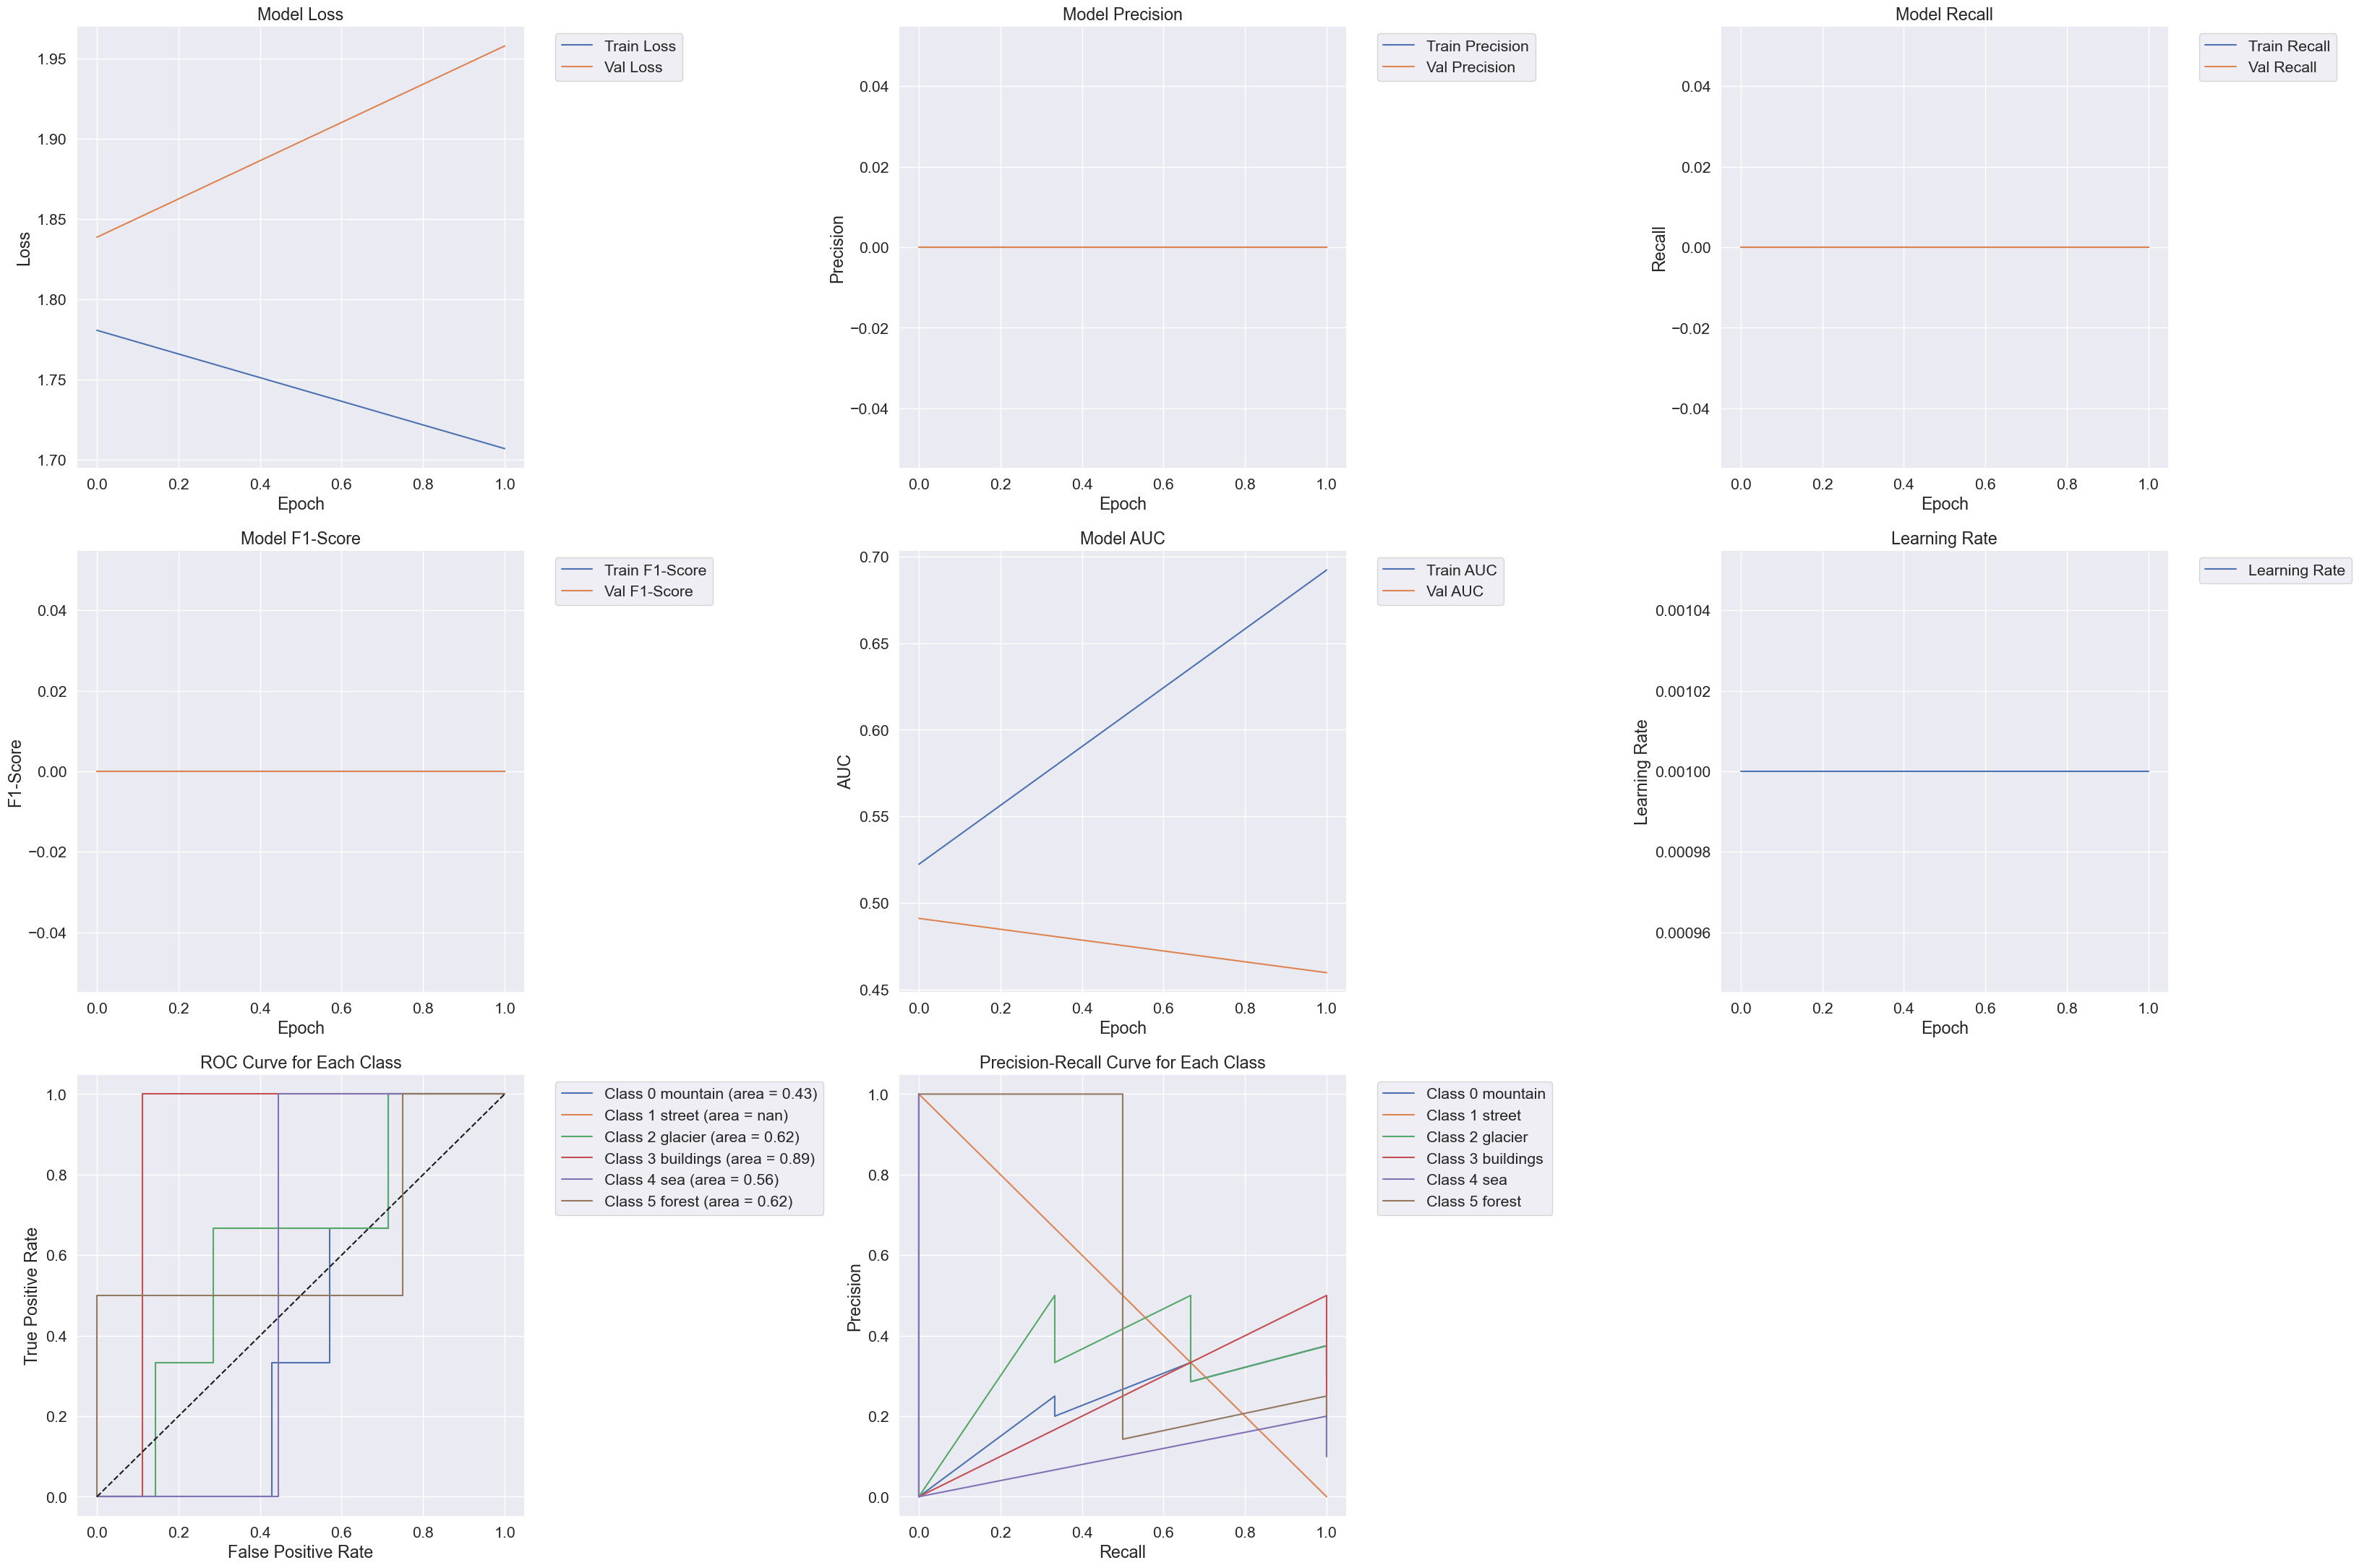

In [15]:
plot_metrics(history, model=custom_cnn_model, val_dataset=val_dataset, labels_dict=labels_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confusion Matrix:
[[0 3 0 0 0 0]
 [0 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 2 0 0 0 0]]


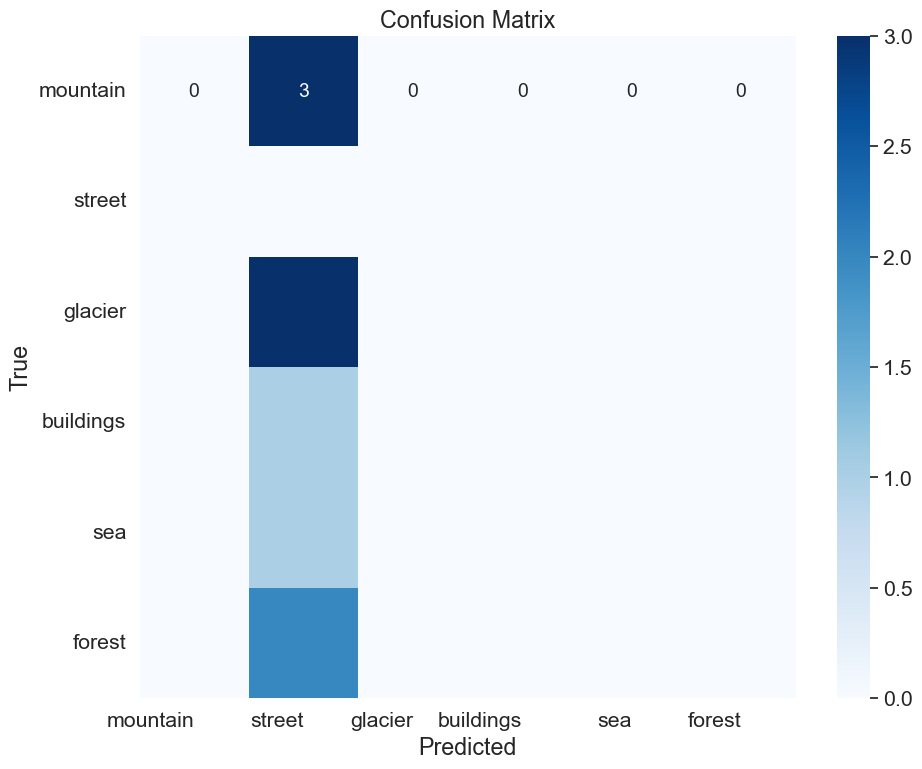

Classification Report:
              precision    recall  f1-score   support

    mountain       0.00      0.00      0.00       3.0
      street       0.00      0.00      0.00       0.0
     glacier       0.00      0.00      0.00       3.0
   buildings       0.00      0.00      0.00       1.0
         sea       0.00      0.00      0.00       1.0
      forest       0.00      0.00      0.00       2.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



In [52]:
# Get validation information
result = custom_cnn_model.get_val_info(val_dataset)
y_true, y_pred_prob = result['y_true'], result['y_pred_prob']
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.values(), yticklabels=labels_dict.values(), annot_kws={"size": 14})  # Increase annotation font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=labels_dict.values())
print("Classification Report:")
print(class_report)

## Testing

In [16]:
result = custom_cnn_model.predict_batch(test_dataset=test_dataset, labels_dict=labels_dict)
for i in np.unique(result, return_counts=True):
    print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
['street']
[10]


## Save result

In [17]:
# Save the entire model
custom_cnn_model.save(SAVE_PATH + 'custom_cnn_model.keras')

In [18]:
with open(SAVE_PATH + 'training_history_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


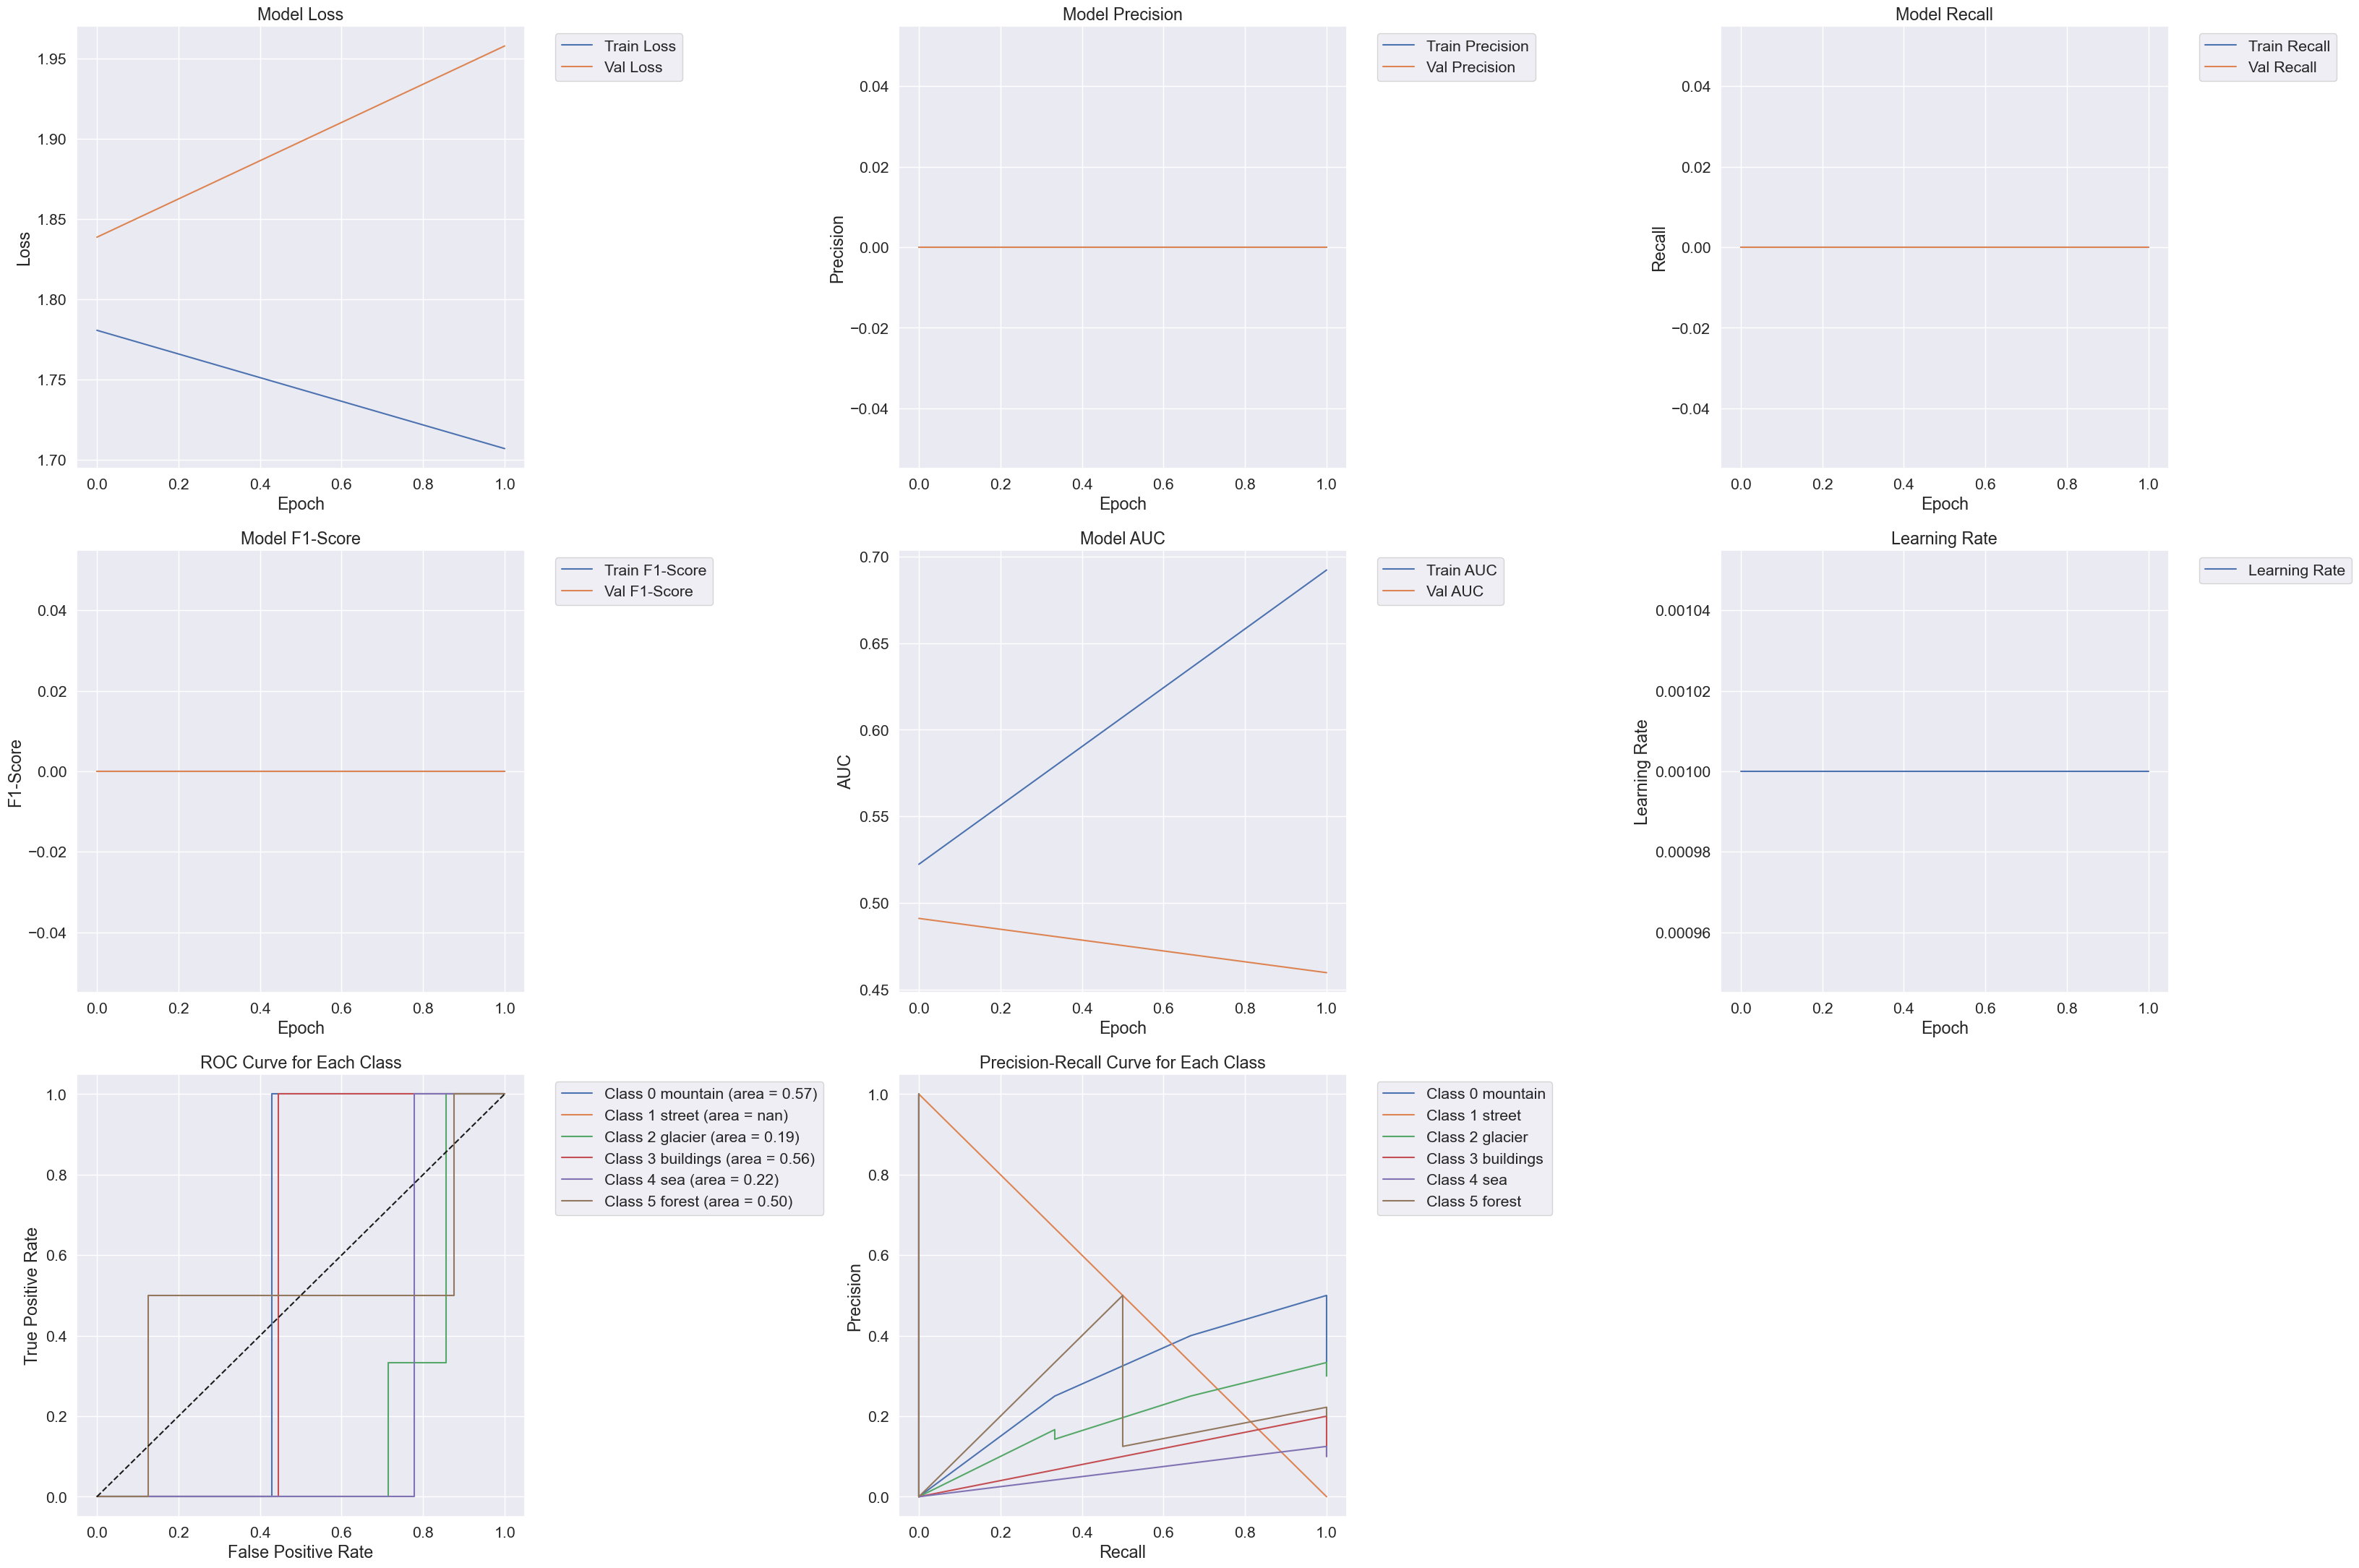

In [19]:
with open(SAVE_PATH + 'training_history_1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history, model=model)

# Hyperparameter tuning

In [20]:
class CustomCNNHyperModel(kt.HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), 
                         (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64), 
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128), 
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=256), 
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)))

        # Output Layer for classification
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with 6 units for 6 classes

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=[
                          'accuracy',  # Built-in accuracy for sparse labels
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.AUC(name='auc', multi_label=True),  # AUC for multiclass
                      ])
        return model
    
    def get_val_info(self, val_dataset=val_dataset):
        # Get true labels and predicted probabilities
        y_true = []
        y_pred_prob = []
        
        # Iterate through validation dataset and collect true labels and predicted probabilities
        for batch in val_dataset:
            x_val, y_val = batch  # x_val: validation features, y_val: validation true labels
            y_true.extend(y_val.numpy())  # Collect true labels
            
            # Predict the probabilities for each class
            preds = self.model.predict(x_val)
            y_pred_prob.extend(preds)
        
        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_true = np.argmax(y_true, axis=-1)  # Convert one-hot encoded labels to categorical labels
        y_pred_prob = np.array(y_pred_prob)

        return {
            'y_true': y_true,  # Return true labels
            'y_pred_prob': y_pred_prob  # Return predicted probabilities
        }

# Create an instance of the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES)

# Hyperparameter tuning with Hyperband
tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=EPOCHS,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='custom_cnn',
    overwrite=False
)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 256, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 256, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [21]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'BestCustomCNN', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Search for the best hyperparameters
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

Trial 2 Complete [00h 00m 06s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 12s
{'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 256, 'conv4_filters': 256, 'dense_units': 1024, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0006129026436388703, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [22]:
# Train the model with the best hyperparameters
history_best = best_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

Epoch 1/2


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2000 - auc: 0.5945 - loss: 1.7493 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.4312 - val_loss: 1.8758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 6.1290e-04
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.4000 - auc: 0.4157 - loss: 1.7340 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_auc: 0.3353 - val_loss: 1.9414 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 6.1290e-04


In [23]:
# Evaluate the best model
result = best_model.evaluate(val_dataset)
loss, accuracy, precision, recall, auc = result
print(f'Testing Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - auc: 0.4312 - loss: 1.8758 - precision: 0.0000e+00 - recall: 0.0000e+00
Testing Loss: 1.8758, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, AUC: 0.4312


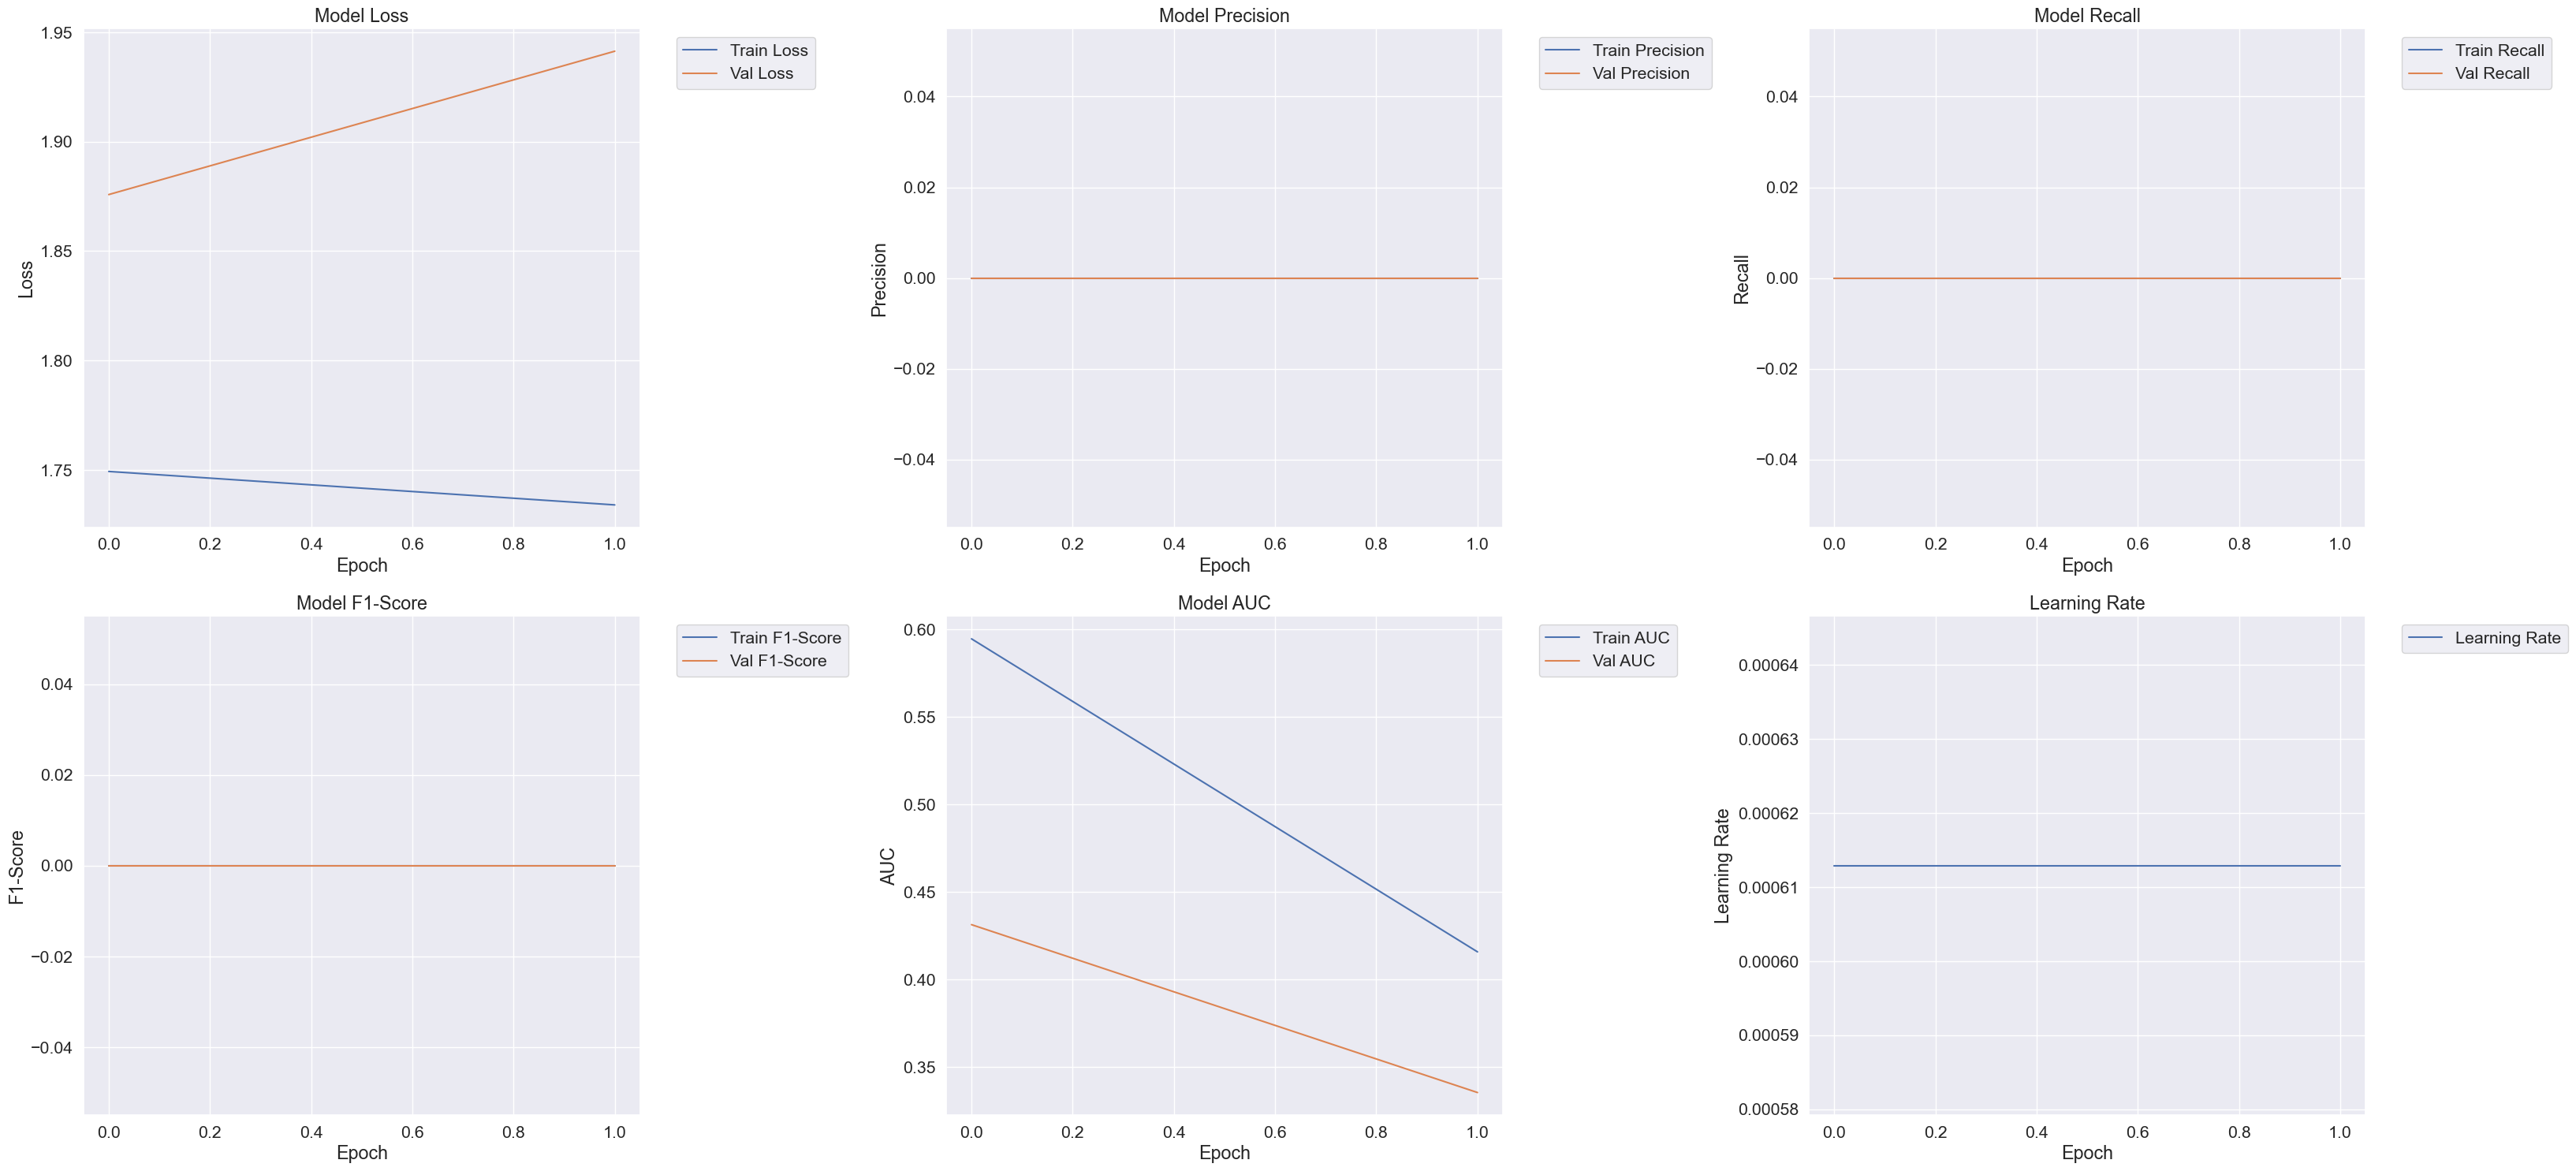

In [24]:
def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('learning_rate', []),
    }
    
    # Calculate F1-score for each epoch (if precision and recall are available)
    metrics['f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                           for p, r in zip(metrics['precision'], metrics['recall'])]
    metrics['val_f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                               for p, r in zip(metrics['val_precision'], metrics['val_recall'])]

    epochs = range(1, len(metrics['loss']) + 1)

    plt.figure(figsize=(33, 22))

    # Plot Loss
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot Precision
    plt.subplot(3, 3, 2)
    plt.plot(metrics['precision'], label='Train Precision')
    plt.plot(metrics['val_precision'], label='Val Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot Recall
    plt.subplot(3, 3, 3)
    plt.plot(metrics['recall'], label='Train Recall')
    plt.plot(metrics['val_recall'], label='Val Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot F1-score
    plt.subplot(3, 3, 4)
    plt.plot(metrics['f1_score'], label='Train F1-Score')
    plt.plot(metrics['val_f1_score'], label='Val F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot AUC
    plt.subplot(3, 3, 5)
    plt.plot(metrics['auc'], label='Train AUC')
    plt.plot(metrics['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot learning rate
    plt.subplot(3, 3, 6)
    plt.plot(metrics['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
plot_metrics(history_best)

In [25]:
# Save the entire model
best_model.save(SAVE_PATH + 'best_custom_cnn_model.keras')

In [26]:
# Save the training history
with open(SAVE_PATH + 'training_history_best.pkl', 'wb') as file:
    pickle.dump(history.history, file)

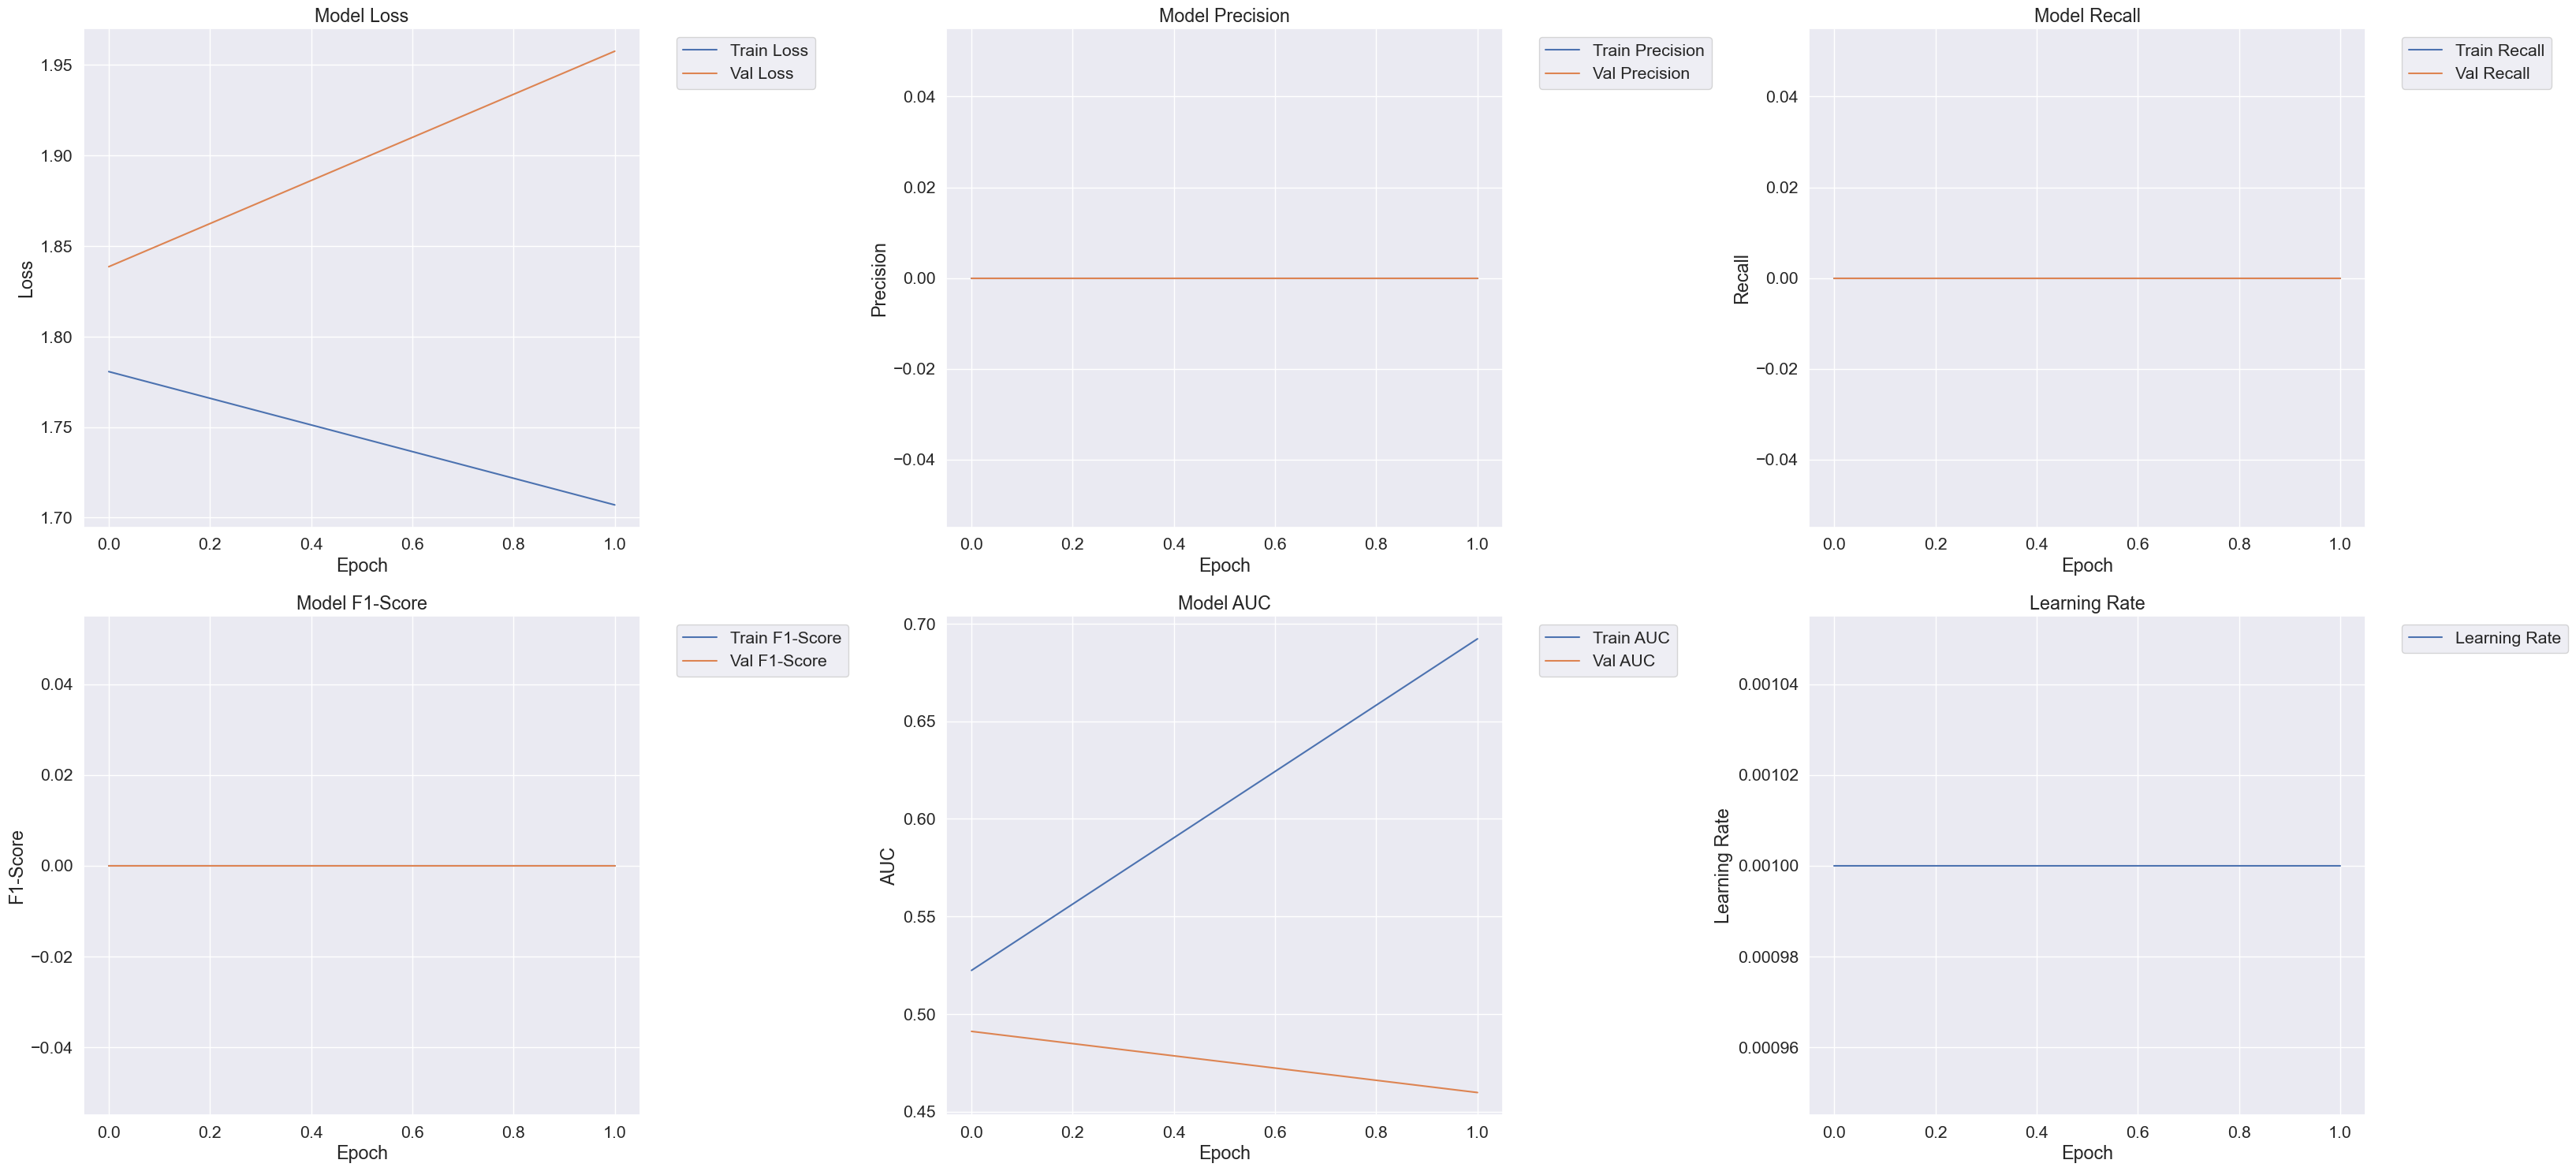

In [37]:
# Load the training history
with open(SAVE_PATH + 'training_history_best.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Create an empty history object
empty_history = model.train(train_dataset, val_dataset=val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

# Error analysis

In [57]:
# Save the dictionary to a file
with open(SAVE_PATH + 'best_hyperparameters.pkl', 'wb') as file:
    pickle.dump(best_hyperparameters.values, file)

# Load the dictionary from the file
with open(SAVE_PATH + 'best_hyperparameters.pkl', 'rb') as file:
    loaded_hyperparameters = pickle.load(file)

print(loaded_hyperparameters)

{'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 256, 'conv4_filters': 256, 'dense_units': 1024, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0006129026436388703, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [66]:
best_model = CustomCNNModel()
best_model.build(best_hyperparameters)

best_model.load_weights(SAVE_PATH + 'best_custom_cnn_model.keras')
best_model.model.summary()

AttributeError: 'CustomCNNModel' object has no attribute 'build'

In [73]:
result = best_model.model.predict(val_dataset)
result = np.argmax(result, axis=1)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

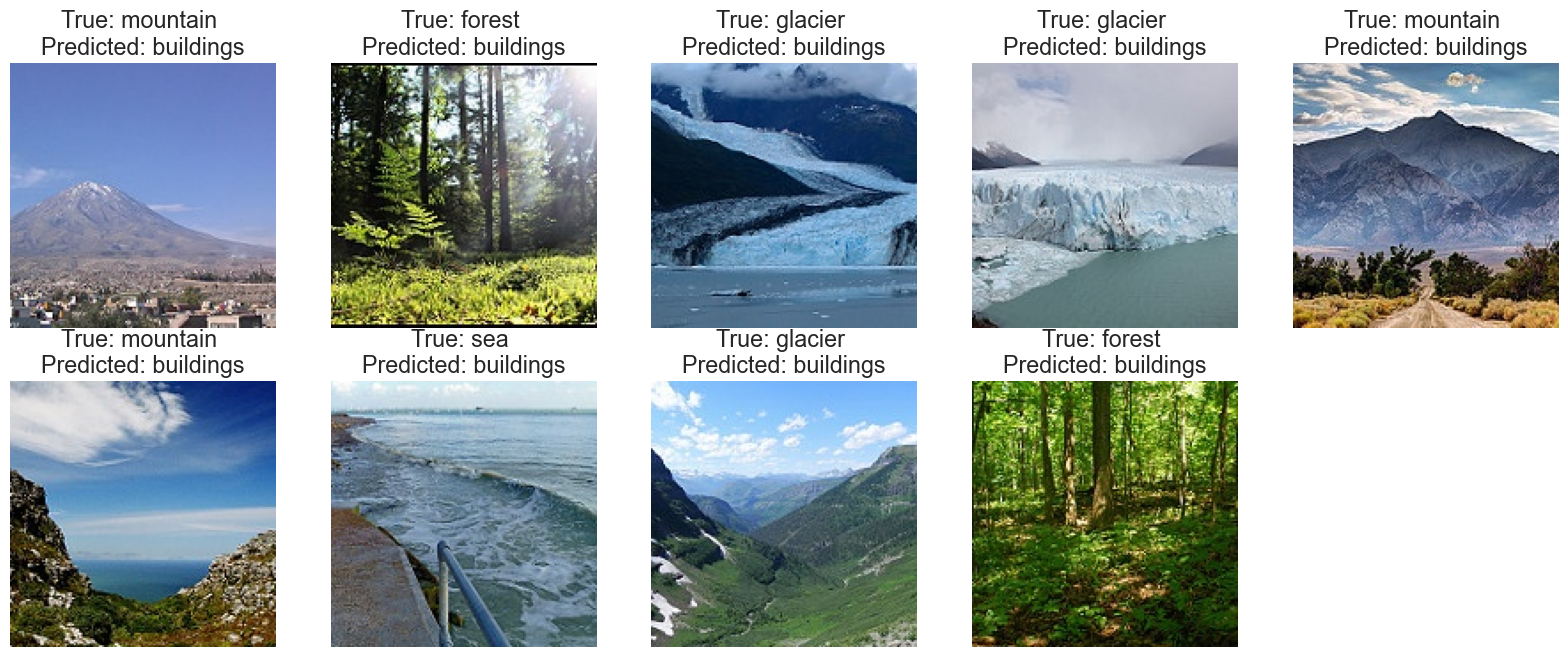

In [87]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    plt.figure(figsize=(20, 20))
    for i in range(len(mislabeled_indices[0])):
        plt.subplot(5, 5, i + 1)
        plt.imshow(mislabeled_images[i])
        plt.title(f'True: {class_names[test_labels[mislabeled_indices][i]]} \nPredicted: {class_names[mislabeled_labels[i]]}')
        plt.axis('off')

print_mislabeled_images(labels_dict, X_val, Y_val, result)


Confusion Matrix:
[[0 0 3 0 0]
 [0 0 3 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 2 0 0]]


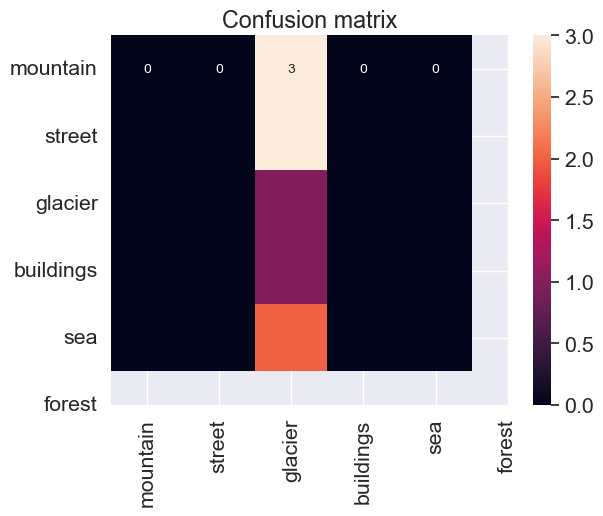

In [88]:
CM = confusion_matrix(Y_val, result)
print("Confusion Matrix:")
print(CM)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=labels_dict.values(), 
           yticklabels=labels_dict.values(), ax = ax)
ax.set_title('Confusion matrix')
plt.show()